<a href="https://colab.research.google.com/github/elenadigrigoli/FDS-project/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from deep_learing_utils import *


In [5]:
!git clone https://github.com/elenadigrigoli/FDS-project.git

Cloning into 'FDS-project'...
remote: Enumerating objects: 43707, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 43707 (delta 9), reused 10 (delta 4), pack-reused 43682 (from 3)
Receiving objects: 100% (43707/43707), 1.22 GiB | 17.54 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Updating files: 100% (43437/43437), done.


In [30]:
train_path = '/content/FDS-project/final dataset/train'
test_path = '/content/FDS-project/final dataset/test'

# Transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1)),
])

# Load training and test datasets
train_dataset_full = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

class_names = train_dataset_full.classes

# Compute dataset sizes
train_size = int(0.85 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Classes in the dataset: {class_names}")


Classes in the dataset: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


Training Set:


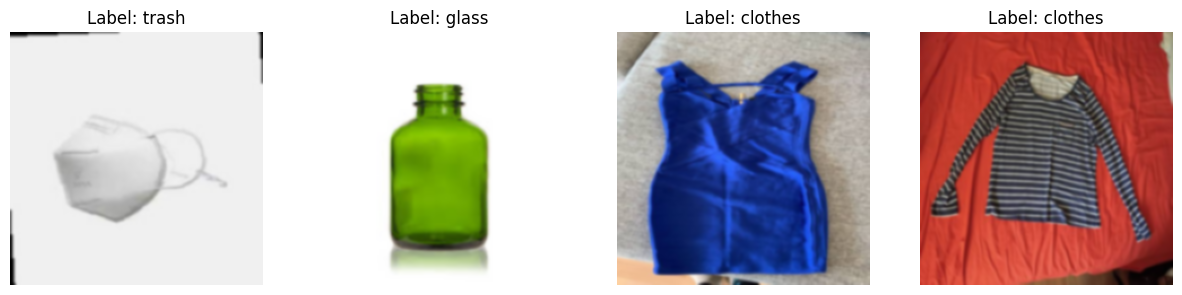

Validation Set:


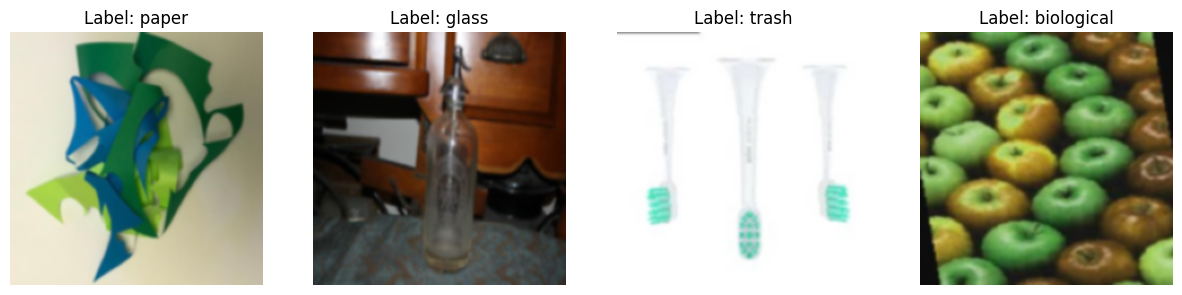

Test Set:


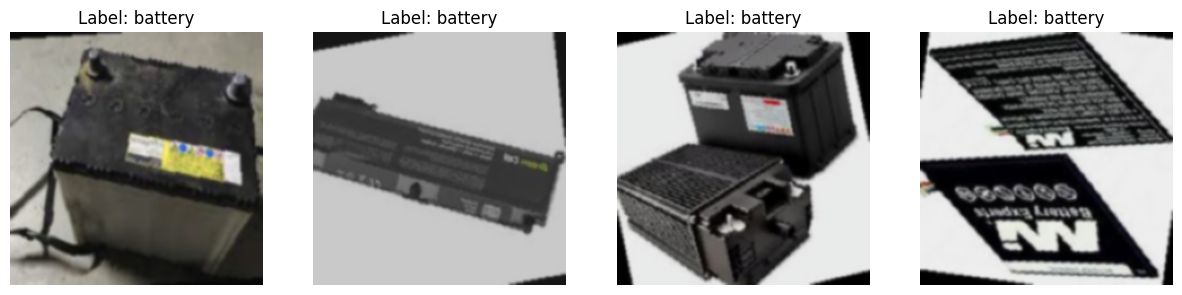

In [33]:
# Parameters for normalization (standard ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Display a batch from the training set
print("Training Set:")
show_images_from_loader(train_loader, train_dataset_full, mean, std)

# Display a batch from the validation set
print("Validation Set:")
show_images_from_loader(val_loader, train_dataset_full, mean, std)

# Display a batch from the test set
print("Test Set:")
show_images_from_loader(test_loader, test_dataset, mean, std)



In [32]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)

# Modify the final layer for 10 classes
num_classes = 10
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to GPU (if available)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_dataset):.4f}")



Epoch 1/10, Loss: 0.4885
Validation Loss: 0.2806, Accuracy: 0.9129
Epoch 2/10, Loss: 0.2502
Validation Loss: 0.2596, Accuracy: 0.9229
Epoch 3/10, Loss: 0.1902
Validation Loss: 0.2238, Accuracy: 0.9294
Epoch 4/10, Loss: 0.1528
Validation Loss: 0.2055, Accuracy: 0.9375
Epoch 5/10, Loss: 0.1334
Validation Loss: 0.2078, Accuracy: 0.9367
Epoch 6/10, Loss: 0.1033
Validation Loss: 0.2590, Accuracy: 0.9256
Epoch 7/10, Loss: 0.0993
Validation Loss: 0.2200, Accuracy: 0.9394
Epoch 8/10, Loss: 0.0995
Validation Loss: 0.2657, Accuracy: 0.9332
Epoch 9/10, Loss: 0.0833
Validation Loss: 0.2347, Accuracy: 0.9351
Epoch 10/10, Loss: 0.0769
Validation Loss: 0.2624, Accuracy: 0.9348


In [10]:


# Model testing with collection of predictions and true labels
model.eval()
test_loss, correct = 0.0, 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        predictions = outputs.argmax(1)
        correct += (predictions == labels).sum().item()

        # Save predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Print main results
accuracy = correct / len(test_dataset)
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Test Loss: 0.2242, Accuracy: 0.9441

Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.90      0.93       300
  biological       0.93      0.97      0.95       300
   cardboard       0.94      0.97      0.95       362
     clothes       1.00      0.98      0.99      1065
       glass       0.95      0.92      0.93       608
       metal       0.81      0.92      0.86       300
       paper       0.96      0.91      0.93       330
     plastic       0.93      0.90      0.92       383
       shoes       0.94      0.97      0.96       396
       trash       0.91      0.93      0.92       300

    accuracy                           0.94      4344
   macro avg       0.93      0.94      0.93      4344
weighted avg       0.95      0.94      0.94      4344



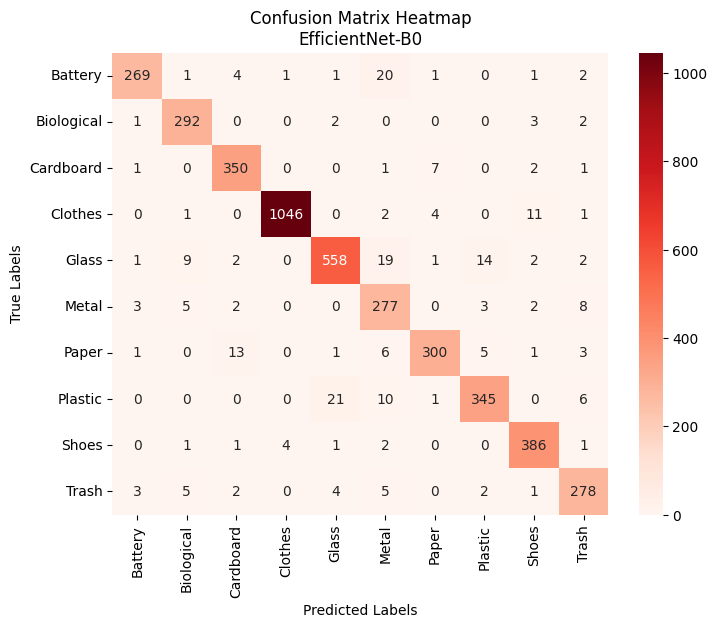

In [29]:

labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nEfficientNet-B0')
plt.show()

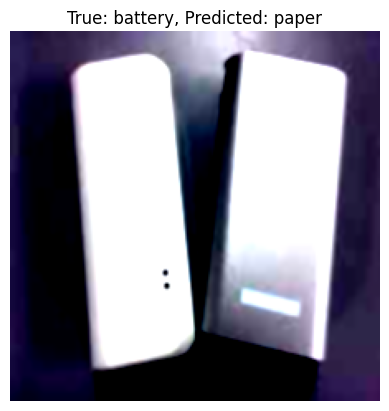

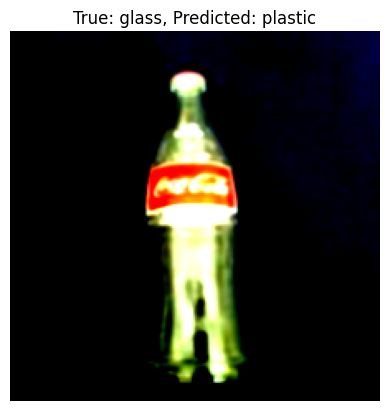

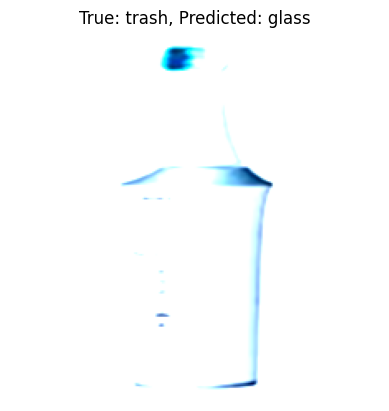

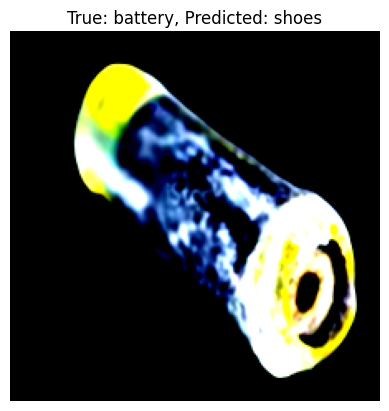

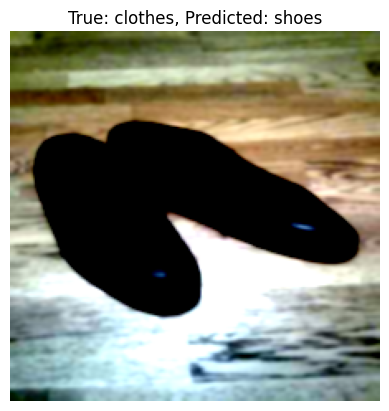

In [13]:

# Iterate to identify misclassified images
wrong_predictions = []
for i in range(len(all_labels)):
    if all_labels[i] != all_predictions[i]:
        wrong_predictions.append(i)

# Display a sample of misclassified images
wrong_samples = np.random.choice(wrong_predictions, min(5, len(wrong_predictions)), replace=False)

for idx in wrong_samples:
    image, true_label, pred_label = test_loader.dataset[idx][0], all_labels[idx], all_predictions[idx]
    plt.imshow(image.permute(1, 2, 0))  # Convert the tensor to an image
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
    plt.axis("off")
    plt.show()


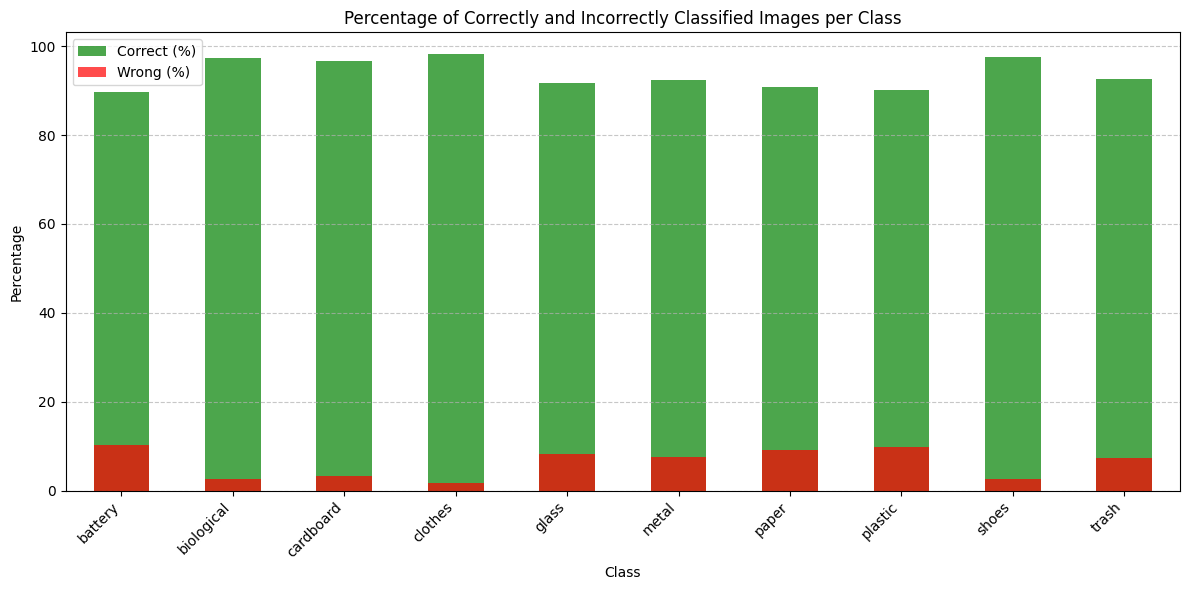

In [15]:


# Count total images per class
all_labels = np.array(all_labels)  # Convert to array for easier calculations
all_predictions = np.array(all_predictions)

total_counts = pd.Series(all_labels).value_counts().reindex(range(len(class_names)), fill_value=0)

# Count correctly classified images
correct_indices = all_labels == all_predictions
correct_labels = all_labels[correct_indices]
correct_counts = pd.Series(correct_labels).value_counts().reindex(range(len(class_names)), fill_value=0)

# Count incorrectly classified images
wrong_counts = total_counts - correct_counts

# Calculate percentages
correct_percentages = (correct_counts / total_counts) * 100
wrong_percentages = (wrong_counts / total_counts) * 100

# Convert to DataFrame with class names
distribution = pd.DataFrame({
    'Correct (%)': correct_percentages,
    'Wrong (%)': wrong_percentages
})
distribution.index = class_names

# Plot overlapping bar charts
plt.figure(figsize=(12, 6))
distribution['Correct (%)'].plot(kind='bar', color='green', alpha=0.7, label='Correct (%)')
distribution['Wrong (%)'].plot(kind='bar', color='red', alpha=0.7, label='Wrong (%)')
plt.title('Percentage of Correctly and Incorrectly Classified Images per Class')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

